In [54]:
# Phase 1

# 1.1

## given diabetic_data.csv file into a Pandas Dataframe
import pandas as pd
import numpy as np

df = pd.read_csv('data_files/diabetic_data.csv')

## Initial check

df.head()
df.info()
df.describe()
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [64]:
#1.2

##  process the dataframe to interpret ? as a standard NumPy NaN value.
import pandas as pd
df = pd.read_csv('data_files/diabetic_data.csv', na_values='?')

if df['weight'].isnull().mean() > 0.90:
    df.drop(columns=['weight'], inplace=True)
    print("Dropped")
print(df['race'][20])    

    

Dropped
nan


C:\Users\Dell\AppData\Local\Temp\ipykernel_16440\379766289.py:5: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data_files/diabetic_data.csv', na_values='?')


In [65]:
#1.3

# read IDS_mapping file
mapping_df = pd.read_csv('data_files/IDs_mapping.csv' ,skiprows=10, nrows=31)

# marge df and mapping_df file
merged_df = pd.merge(df, mapping_df, on='discharge_disposition_id', how='left')

#find indexs for expired
expired_index = merged_df[
    merged_df['description'].str.contains('Expired', case=False, na=False)
].index

#before drop check df length
before = len(df)
#drop have expired rows and save df
df = merged_df.drop(expired_index)

#check new length of df
after = len(df)

print("Before:", before)
print("After:", after)
#check removed rows
print("Removed:", before - after)


Before: 101766
After: 100114
Removed: 1652


In [66]:

#1.4

#Deduplication Strategy

#check for exact duplicate rows and count total number
duplicate_count = df.duplicated().sum()
print(duplicate_count)

#before drop check df length
before_drop = len(df)
#Remove the exact duplicate rows and assign the cleaned DataFrame back to the variable 'df'.
df = df.drop_duplicates()
##before drop check df length
after_drop = len(df)
#check removed rows
print(before_drop - after_drop)

0
0


In [69]:
# Phase 2

# 2.1

import pandas as pd

# read diabetic_data.csv file

# count diag_1 codes and select max 20
top_20_codes = df['diag_1'].value_counts().head(20)
print(top_20_codes)


diag_1
428      6735
414      6555
786      4016
410      3477
486      3413
427      2729
491      2252
715      2147
682      2030
780      2012
434      1958
996      1944
276      1861
250.8    1667
599      1581
38       1522
584      1482
V57      1204
250.6    1178
820      1075
Name: count, dtype: int64


In [70]:
#2.2

import requests
from bs4 import BeautifulSoup
import time

#defined the function for web scraping
def get_icd9_details(code):

    #base url of the icd9 website
    url = 'http://icd9.chrisendres.com/index.php'

    # parameters that the website's search engine expects
    params = {
        'srchtype': 'diseases',
        'srchtext': str(code),
        'action' : 'search'
    }

    #send get request to url within paramters
    response = requests.get(url , params=params)

    #Check if the server responded successfully
    if response.status_code == 200:

        # Converts the raw HTML text into a structured soup object
        soup = BeautifulSoup(response.text, 'html.parser')

        #find <div> tag has the class name
        result = soup.find('div', class_= 'dlvl')

        if result:
            print(f'Code{code} fetched')
            #If the <div> was found, extract and return its text content
            return result.text.strip()
        else:
            #can't found to div element, return this
            return "Description Not Found"
    else:
        # If the website fails to load
        print(f'Failed code {code}')
        return "Fetch Failed"    

#A dictionary to store the results, it's used to both of code and description to store 
icd9_mapping = {}

## Loop through Top 20 codes identified 
for code in top_20_codes.index:
    # Call the function to scrape the description for the current code
    description = get_icd9_details(code)

    ## Store the result in our dictionary
    icd9_mapping[code] = description

    ## Print the final result for each code
    print(f'{code} -> {description}')

    ## Wait for 1 second before the next request to avoid getting blocked
    time.sleep(1)



Code428 fetched
428 -> 428 Heart failure
Code414 fetched
414 -> 414 Other forms of chronic ischemic heart disease
Code786 fetched
786 -> 786 Symptoms involving respiratory system and other chest symptoms
Code410 fetched
410 -> 410 Acute myocardial infarction
Code486 fetched
486 -> 486 Pneumonia, organism unspecified
Code427 fetched
427 -> 427 Cardiac dysrhythmias
Code491 fetched
491 -> 491 Chronic bronchitis
Code715 fetched
715 -> 715 Osteoarthrosis and allied disorders
Code682 fetched
682 -> 682 Other cellulitis and abscess
Code780 fetched
780 -> 780 General symptoms
Code434 fetched
434 -> 434 Occlusion of cerebral arteries
Code996 fetched
996 -> 996 Complications peculiar to certain specified procedures
Code276 fetched
276 -> 276 Disorders of fluid, electrolyte, and acid-base balance
Code250.8 fetched
250.8 -> 250.8 Diabetes with other specified manifestations
Code599 fetched
599 -> 599 Other disorders of urethra and urinary tract
38 -> Description Not Found
Code584 fetched
584 -> 58

In [71]:
#2.3

# map icd9_mapping for new column Primary_Diagnosis_Desc
df['Primary_Diagnosis_Desc'] = df['diag_1'].map(icd9_mapping)

# outside the top 20, label them as "Other" using fillna
df['Primary_Diagnosis_Desc'] = df['Primary_Diagnosis_Desc'].fillna('Other')

#print first 10 rows to see the result
print(df[['diag_1' , 'Primary_Diagnosis_Desc']].head(10))

   diag_1                             Primary_Diagnosis_Desc
0  250.83                                              Other
1     276  276 Disorders of fluid, electrolyte, and acid-...
2     648                                              Other
3       8                                              Other
4     197                                              Other
5     414  414 Other forms of chronic ischemic heart disease
6     414  414 Other forms of chronic ischemic heart disease
7     428                                  428 Heart failure
8     398                                              Other
9     434                 434 Occlusion of cerebral arteries


C:\Users\Dell\AppData\Local\Temp\ipykernel_16440\1570160690.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='readmitted', palette='viridis')


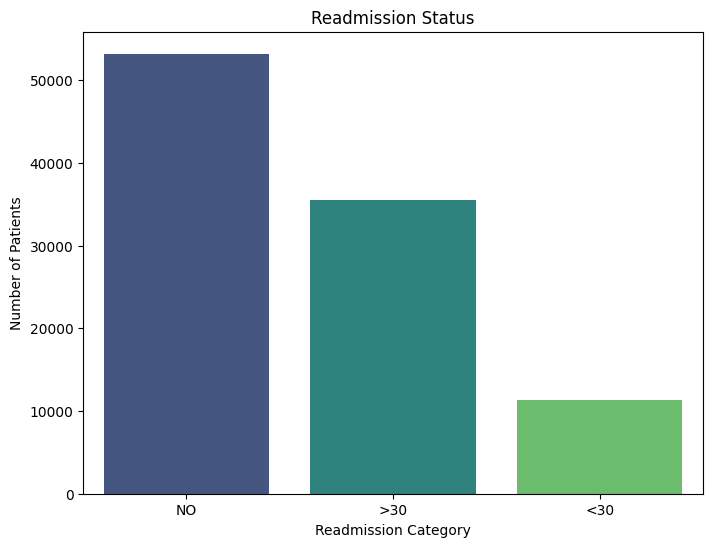

In [72]:
# 3

#3.1

import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(8,6))

sns.countplot(data=df, x='readmitted', palette='viridis')

plt.title('Readmission Status')
plt.xlabel('Readmission Category')
plt.ylabel('Number of Patients')
plt.show()

C:\Users\Dell\AppData\Local\Temp\ipykernel_16440\1393339076.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='age', order=age_order, palette='magma')


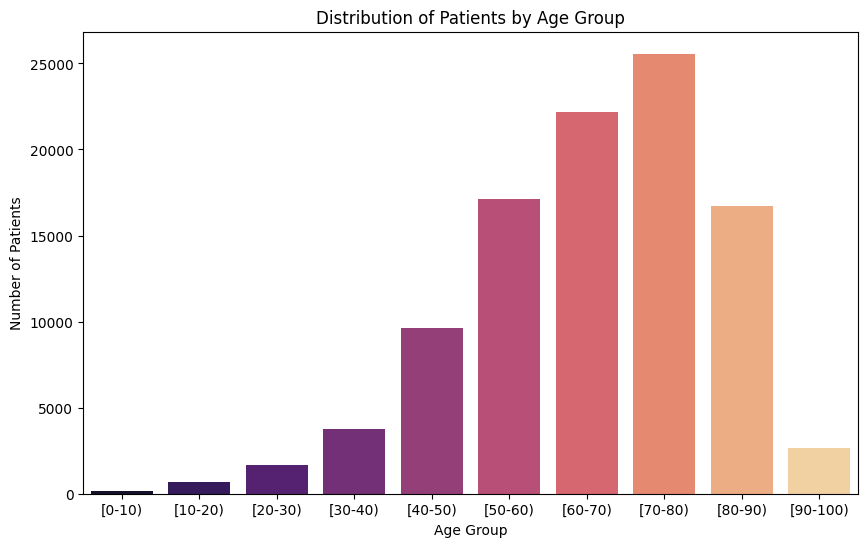

In [ ]:
# 3.2.1

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


plt.figure(figsize=(10, 6))
age_order = sorted(df['age'].unique())

sns.countplot(data=df, x='age', order=age_order, palette='magma')

plt.title('Distribution of Patients by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number of Patients')
plt.show()

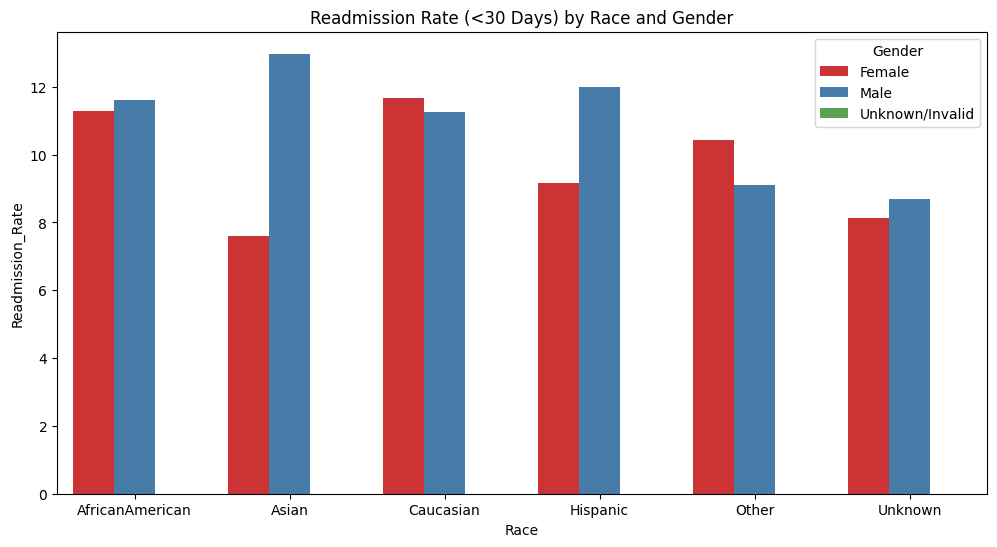

In [ ]:
#3.2.2


df['race'] = df['race'].fillna('Unknown')
ct = pd.crosstab(index=[df['race'], df['gender']], columns=df['readmitted'], normalize='index') * 100
grouped_data = ct['<30'].reset_index()
grouped_data.columns = ['Race', 'Gender', 'Readmission_Rate']

plt.figure(figsize=(12, 6))
sns.barplot(data=grouped_data, x='Race', y='Readmission_Rate', hue='Gender', palette='Set1')
plt.title('Readmission Rate (<30 Days) by Race and Gender')
plt.show()

Med_Category
Insulin           12.353558
Oral Meds Only    10.759624
No Medication      9.783166
Name: <30, dtype: float64


C:\Users\Dell\AppData\Local\Temp\ipykernel_16440\852732340.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=med_analysis.index, y=med_analysis['<30'], palette='viridis')


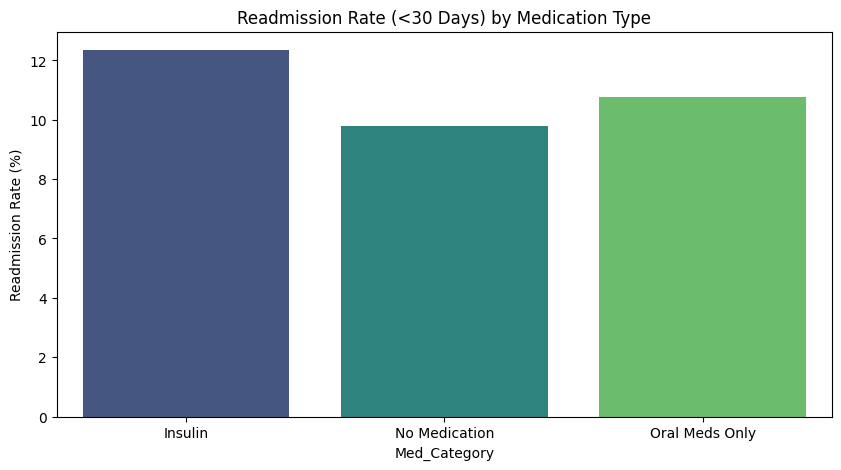

In [ ]:
#3.3.1

oral_meds = df.columns[24:46].tolist()

df['taking_oral'] = df[oral_meds].apply(lambda x: x != 'No').any(axis=1)
df['taking_insulin'] = df['insulin'] != 'No'

def categorize_meds(row):
    if row['taking_insulin']:
        return 'Insulin'
    elif row['taking_oral']:
        return 'Oral Meds Only'
    else:
        return 'No Medication'

df['Med_Category'] = df.apply(categorize_meds, axis=1)

med_analysis = pd.crosstab(df['Med_Category'], df['readmitted'], normalize='index') * 100
print(med_analysis['<30'].sort_values(ascending=False))

plt.figure(figsize=(10, 5))
sns.barplot(x=med_analysis.index, y=med_analysis['<30'], palette='viridis')
plt.title('Readmission Rate (<30 Days) by Medication Type')
plt.ylabel('Readmission Rate (%)')
plt.show()

change
Ch    11.967358
No    10.804718
Name: <30, dtype: float64


C:\Users\Dell\AppData\Local\Temp\ipykernel_16440\2175946809.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=change_analysis.index, y=change_analysis['<30'], palette='coolwarm')


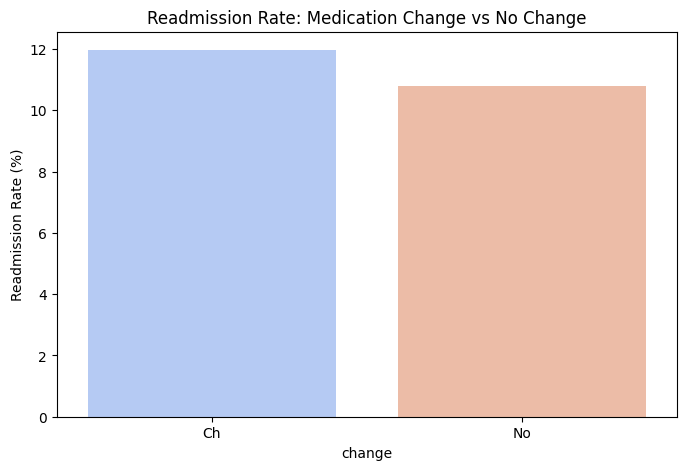

In [ ]:
#3.3.2

change_analysis = pd.crosstab(df['change'], df['readmitted'], normalize='index') * 100
print(change_analysis['<30'])

plt.figure(figsize=(8, 5))
sns.barplot(x=change_analysis.index, y=change_analysis['<30'], palette='coolwarm')
plt.title('Readmission Rate: Medication Change vs No Change')
plt.ylabel('Readmission Rate (%)')
plt.show()

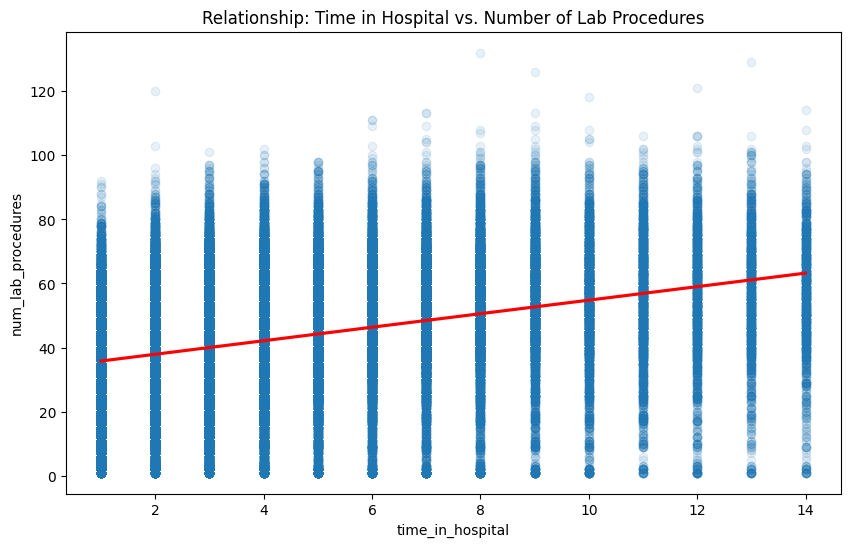

Correlation Coefficient: 0.3197540864582981


In [81]:
#3.4.1

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.regplot(data=df, x='time_in_hospital', y='num_lab_procedures', 
            scatter_kws={'alpha':0.1}, line_kws={'color':'red'})
plt.title('Relationship: Time in Hospital vs. Number of Lab Procedures')
plt.show()

correlation = df['time_in_hospital'].corr(df['num_lab_procedures'])
print(f"Correlation Coefficient: {correlation}")


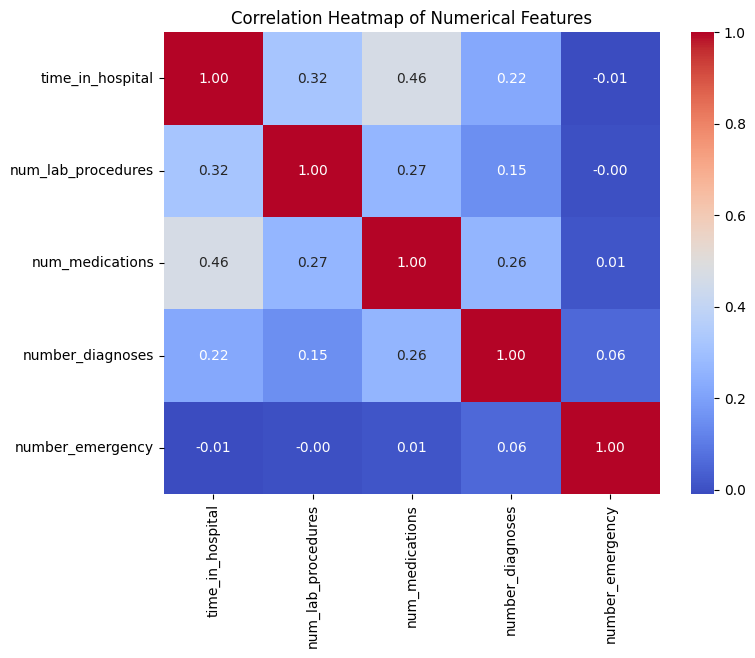

In [82]:
#3.4.2

cols = ['time_in_hospital', 'num_lab_procedures', 'num_medications', 
        'number_diagnoses', 'number_emergency']
corr_matrix = df[cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

C:\Users\Dell\AppData\Local\Temp\ipykernel_16440\473765404.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_df, x='readmitted', y='time_in_hospital', palette='Set2')


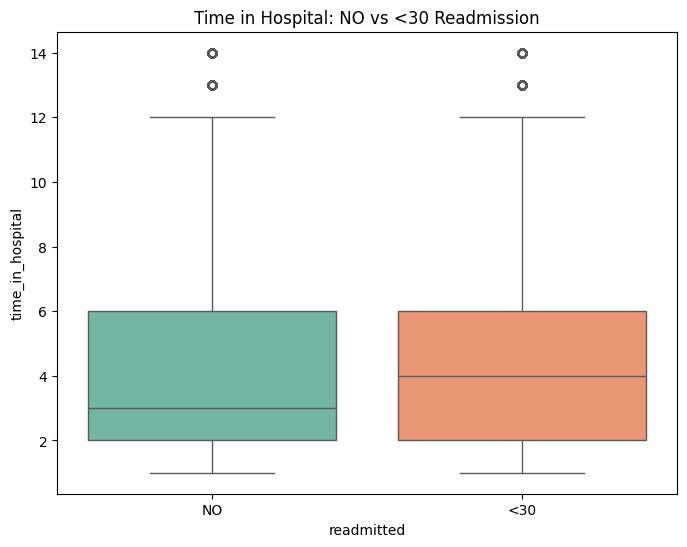

In [83]:
#3.4.3

plt.figure(figsize=(8, 6))
filtered_df = df[df['readmitted'].isin(['NO', '<30'])]

sns.boxplot(data=filtered_df, x='readmitted', y='time_in_hospital', palette='Set2')
plt.title('Time in Hospital: NO vs <30 Readmission')
plt.show()

Discharge_Location
Home                         9.300395
Other                       14.306102
Skilled Nursing Facility    14.662462
Name: <30, dtype: float64


C:\Users\Dell\AppData\Local\Temp\ipykernel_16440\903611440.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=discharge_analysis.index, y=discharge_analysis['<30'], palette='mako')


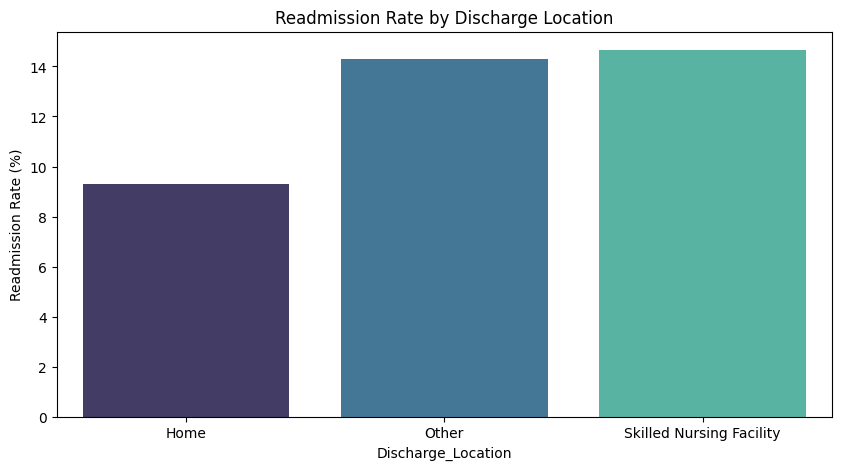

In [84]:
#3.4.4


def discharge_label(id):
    if id == 1: return 'Home'
    elif id == 3: return 'Skilled Nursing Facility'
    else: return 'Other'

df['Discharge_Location'] = df['discharge_disposition_id'].apply(discharge_label)

discharge_analysis = pd.crosstab(df['Discharge_Location'], df['readmitted'], normalize='index') * 100
print(discharge_analysis['<30'])

plt.figure(figsize=(10, 5))
sns.barplot(x=discharge_analysis.index, y=discharge_analysis['<30'], palette='mako')
plt.title('Readmission Rate by Discharge Location')
plt.ylabel('Readmission Rate (%)')
plt.show()

In [85]:
import pandas as pd

def calculate_L_points(days):
    if days < 1:
        return 0
    elif 1 <= days <= 4:
        return 1
    elif 5 <= days <= 13:
        return 4
    elif days >= 14:
        return 7
    else:
        return 0


df['VCI_Score'] = df['time_in_hospital'].apply(calculate_L_points)

print(df[['time_in_hospital', 'VCI_Score']].head(10))

   time_in_hospital  VCI_Score
0                 1          1
1                 3          1
2                 2          1
3                 2          1
4                 1          1
5                 3          1
6                 4          1
7                 5          4
8                13          4
9                12          4
